# **Mini-Project 2**

# 1. **Introduction:**
In this project, we define a **weighted inner product** on $\mathbb{C}^n$ and prove that it induces a **weighted norm**.
After establishing the proof, we apply this framework to the **MNIST dataset**, constructing complex-valued matrices from image rows and columns.
To measure the structural differences between digit images, we use **Gram-Schmidt orthogonalization**.

# 2. **Proof** : A weighted inner product on $\mathbb{C}^n$ defines a weighted norm on $\mathbb{C}^n$.


Definitions : Let $\mathbf{u}, \mathbf{v} \in \mathbb{C}^n$, and let $\mathbf{w} = (w_1, w_2, \dots, w_n) \in \mathbb{R}^n$ be a vector of **positive weights**, typically chosen as distinct prime numbers.


The **weighted inner product** is defined as:

$$
\langle \mathbf{u}, \mathbf{v} \rangle_w = \sum_{i=1}^n w_i \cdot u_i \cdot \overline{v_i}
$$



The **weighted norm** is then defined as:

$$
\|\mathbf{u}\|_w = \sqrt{\langle \mathbf{u}, \mathbf{u} \rangle_w} = \sqrt{ \sum_{i=1}^n w_i \cdot |u_i|^2 }
$$

In order to prove this as a valid norm, we need to verify the three norm axioms:

1. **Positive definiteness:**

To show that:
$$
\|\mathbf{u}\|_w \geq 0, \quad \text{and} \quad \|\mathbf{u}\|_w = 0 \iff \mathbf{u} = \mathbf{0}
$$


* Each term $w_i \cdot |u_i|^2 \geq 0$ since $w_i > 0$ and $|u_i|^2 \geq 0$.
* If $\|\mathbf{u}\|_w = 0$, then every term $|u_i|^2 = 0$, implying $u_i = 0$ for all $i$, hence $\mathbf{u} = \mathbf{0}$.

Therefore, Positive definiteness holds.

2. **Homogeneity**

To show that:
$$
\|\alpha \mathbf{u}\|_w = |\alpha| \cdot \|\mathbf{u}\|_w \quad \text{for any } \alpha \in \mathbb{C}
$$

We accordingly prove:
$$
\|\alpha \mathbf{u}\|_w = \sqrt{ \sum_{i=1}^n w_i \cdot |\alpha u_i|^2 } = \sqrt{ \sum_{i=1}^n w_i \cdot |\alpha|^2 \cdot |u_i|^2 } = |\alpha| \cdot \sqrt{ \sum_{i=1}^n w_i \cdot |u_i|^2 } = |\alpha| \cdot \|\mathbf{u}\|_w
$$

Therefore, homogeneity holds.

3. **Triangle Inequality**

To show that:
$$
\|\mathbf{u} + \mathbf{v}\|_w \leq \|\mathbf{u}\|_w + \|\mathbf{v}\|_w
$$

We can see that this follows the **Cauchy- Schwarz inequality** for weighted-inner products:

$$
|\langle \mathbf{u}, \mathbf{v} \rangle_w| \leq \|\mathbf{u}\|_w \cdot \|\mathbf{v}\|_w
$$

Using this, and the standard triangle inequality derivaion, we conclude:

$$
\|\mathbf{u} + \mathbf{v}\|_w^2 \leq (\|\mathbf{u}\|_w + \|\mathbf{v}\|_w)^2
$$

As we can see, taking square roots on both the sides proves the triangle inequality.

Thus to conclude, the weighted inner product $\langle \cdot , \cdot \rangle_w$ induces a **valid norm** $\|\cdot\|_w$ on $\mathbb{C}^n$, satisfying all three required properties.

# 3. **Preparing the Dataset**
We will use the **torchvision** library to download and preprocess the MNIST dataset.
We will choose 10 random greyscale images for each digit class (0 to 9), which wil be later used to construct complex valued matrices for our analysis. 


In [1]:
import torch
from torchvision import datasets, transforms
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D




In [2]:
def get_prime_weights(n):   # Generating a diagonal matrix
    primes = []
    candidate = 2
    while len(primes) < n:
        if all(candidate % p != 0 for p in primes):         # Here we check if the candidate is a prime.
            primes.append(candidate)
        candidate += 1
    return np.diag(primes)     # Here, returns as a diagonal matrix.


def weighted_inner_product(x, y, W):    # Here we compute the weighted inner product between two complex vectors x and y,using a diagonal weight matrix.
    return np.conj(x).T @ W @ y

# Computing the weighted norm of a complex vector x using the same weight matrix (W)
def weighted_norm(x, W):

    return np.sqrt(np.real(np.conj(x).T @ W @ x))           # We consider the real part to ensure non-negative integers.


This code above defines a way to measure vectors using a custom weighting scheme based on prime numbers. It creates a diagonal weight matrix, then uses it to compute weighted inner products and norms, which emphasize certain vector components more than others.
Why prime numbers? Because they don’t share common divisors, they help us to ensure that the weights are unique.

Now we will write a code which performs **Gram-Schmidt orthogonalization** using a **weighted inner product** defined by a matrix `W`. Which will produce   a matrix of orthonormal vectors (`Q`) and their coefficients (`R`), where `R` tells us how the original basis were built. `R` can also be referred to a upper-triangular matrix which means all the elements below the main diagonals are zero and only the upper-triangle contains non-zero entries.


In [3]:
def gram_schmidt_weighted(X, W):

    """
    # Now we apply Gram-Schmidt orthogonalization on matrix X using weighted inner product with W where:
      X: (n x m) numpy array of column vectors
      W: (n x n) positive-definite weight matrix
       
       #which returns
    
    # Q_mat: (n x k) matrix with orthonormal columns under weighted inner product and R_mat: (k x m) upper-triangular matrix of coefficients

    """

    n, m = X.shape
    Q = []
    R = np.zeros((m, m), dtype=np.complex128)
    k = 0

    for i in range(m):
        v = X[:, i].copy()
        for j in range(k):
            q = Q[j]
            R[j, i] = (np.conj(q).T @ W @ v) / (np.conj(q).T @ W @ q)
            v -= R[j, i] * q
        norm = np.sqrt(np.real(np.conj(v).T @ W @ v))
        if norm > 1e-10:
            R[k, i] = norm
            Q.append(v / norm)
            k += 1
        else:
            pass

    if k == 0:
        return np.empty((n, 0)), np.empty((0, m))

    Q_mat = np.stack(Q, axis=1)
    R_mat = R[:k, :]
    return Q_mat, R_mat

n = 5
m1 = 3
m2 = 4

W = get_prime_weights(n)    # Here we are generating weighted matrix 

np.random.seed(0)
X1 = np.random.randn(n, m1) + 1j * np.random.randn(n, m1)
X2 = np.random.randn(n, m2) + 1j * np.random.randn(n, m2)

# Here we will apply weighted Gram-Schmidt to get the orthonormal bases Q1 and Q2.

Q1, R1 = gram_schmidt_weighted(X1, W)
Q2, R2 = gram_schmidt_weighted(X2, W)

print("Q1:\n", Q1)
print("R1:\n", R1)
print("\nQ2:\n", Q2)
print("R2:\n", R2)


Q1:
 [[ 0.20724359+0.03920057j  0.08363435+0.17029856j  0.05018208+0.01412238j]
 [ 0.26326359+0.03677968j  0.27973138-0.14010213j -0.28416088-0.09678186j]
 [ 0.11161785+0.07678812j  0.00510725+0.10664174j -0.0870918 -0.11006052j]
 [ 0.04823775+0.26665428j  0.06004696-0.15926527j  0.09214924+0.15802363j]
 [ 0.08940789-0.02199065j  0.0243735 +0.1829177j   0.0236471 +0.18716523j]]
R1:
 [[ 8.51197536+0.j         -1.00600168+1.02477191j -0.34893438-3.59143259j]
 [ 0.        +0.j          7.75777248+0.j          3.58413455-1.7434038j ]
 [ 0.        +0.j          0.        +0.j          6.24944655+0.j        ]]

Q2:
 [[ 1.77405021e-02-0.10252527j -4.00941439e-03-0.01252284j
  -2.04702354e-01+0.03443955j -4.53054555e-01-0.31574176j]
 [-3.98337448e-02-0.00322669j -3.93640999e-04+0.11819674j
   4.81661059e-01-0.05898228j -2.06022234e-01-0.16409763j]
 [-4.43464754e-02-0.07262588j -1.56566878e-01-0.08420903j
  -1.49558525e-01-0.00650531j -1.38161748e-01-0.0786281j ]
 [-1.95357165e-01-0.09310012j  

Using our earlier output we will now normalize the orthonormal basis matrices Q1 and Q2 from weighted Gram-Schmidt so as to have comparable scales which will give us a measure of the delta of how the delta varies. This helps us to understand the structural difference.

In [4]:
from numpy import sqrt, sum, abs, arange

def weighted_norm(vec, weights=None):
    vec = vec.flatten()
    if weights is None:
        weights = arange(1, len(vec) + 1)
    return sqrt(sum(weights * abs(vec)**2))

# Normalize matrices before delta calculation
def normalize_matrix(matrix, weights=None):
    norm = weighted_norm(matrix, weights)
    if norm > 1e-10:
        return matrix / norm
    else:
        return matrix  # or handle zero norm case as needed

# Assuming Q1 and Q2 are already defined from Gram-Schmidt Weighted orthogonalization
normed_Q1 = normalize_matrix(Q1)
normed_Q2 = normalize_matrix(Q2)

min_cols = min(Q1.shape[1], Q2.shape[1])
normed_Q1_small = normalize_matrix(Q1[:, :min_cols])
normed_Q2_small = normalize_matrix(Q2[:, :min_cols])

delta = weighted_norm(normed_Q1_small - normed_Q2_small)
print("Delta between normalized Q1 and Q2 (common cols):", delta)






Delta between normalized Q1 and Q2 (common cols): 1.5301360851427772


In [5]:
# Converting each image into a tensor.
transform = transforms.Compose([transforms.ToTensor()])
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)


In [6]:
# Organizing the MNIST dataset by collecting 10 images (0 to 9).

from collections import defaultdict
digit_images = defaultdict(list)

for img, label in mnist_data:
    if len(digit_images[label]) < 10:
        digit_images[label].append(img.squeeze(0).numpy()) 
    if all(len(images) == 10 for images in digit_images.values()):
        break


# 4. **Image representation in Complex Vector Space**

In this section, we construct a complex-valued matrix where each selected image $I_{k,h}$ is converted into a complex-valued matrix $M_{I_{k,h}}$. 
Here,`k` denotes the digit class (0 to 9) and `h` is the index of the selected image for that digit (0 to 9).
Each column of the matrix is defined as the sum of a row vector (real part) and an imaginary column vector (imaginary part) from the image.  
This transforms each image into a set of complex vectors suitable for later analysis using the weighted norm and Gram-Schmidt process.

This approach transforms the original grayscale image into a complex-valued representation:

$[\text{column}_j = \text{row}_j + i \cdot \text{col}_j]$



In [7]:
GS_matrices = {}

W = get_prime_weights(28) 

for digit in range(10):
    image_list = digit_images[digit]
    n_images = min(10, len(image_list))
    
    print(f"Digit {digit}: Found {len(image_list)} images, processing {n_images}.")
    
    for img_index in range(n_images):
        vec = image_list[img_index]
        image = np.array(vec).reshape(28, 28)
        matrix = np.zeros((28, 28), dtype=np.complex128)

        for j in range(28):
            row = image[j, :]
            col = image[:, j]
            matrix[:, j] = row + 1j * col

        # Normalizing the columns by norm, it is an optional step but helps with numerical stability.
        norms = np.linalg.norm(matrix, axis=0, keepdims=True)
        norms[norms == 0] = 1e-8  # avoid division by zero
        matrix = matrix / norms

        Q, _ = gram_schmidt_weighted(matrix, W)

        GS_matrices[(digit, img_index)] = Q

print(f"Total matrices computed: {len(GS_matrices)}")





Digit 0: Found 10 images, processing 10.
Digit 1: Found 10 images, processing 10.
Digit 2: Found 10 images, processing 10.
Digit 3: Found 10 images, processing 10.
Digit 4: Found 10 images, processing 10.
Digit 5: Found 10 images, processing 10.
Digit 6: Found 10 images, processing 10.
Digit 7: Found 10 images, processing 10.
Digit 8: Found 10 images, processing 10.
Digit 9: Found 10 images, processing 10.
Total matrices computed: 100


In this context, the variables ```digit``` and ```img_index``` correspond respectively to the indices h and k used in the mathematical notation, representing the ```digit class``` and the ```image number``` within that class.

# 5. **Computing Tensor Delta Values Between Gram-Schmidt Orthonormalized Image Matrices**

Here, we treat the complex-valued matrix $M_{I_{k,h}}$ as a set of column vectors.

We apply the standard Gram-Schmidt process to these vectors to obtain an orthonormal basis with respect to the weighted inner product and thereafter the resulting orthonormal vectors are stacked as columns to form the matrix $GS_{I_{k,h}}$

This orthogonalization is essential for the normalized representation of the images.


In the earlier step, the matrix $M_{I_{k,h}}$ which was constructed by embedding image data into complex form. We then orthonormalized its columns using the Gram-Schmidt process to give us Q, which is stored in `GS_matrices`.

In [8]:
from itertools import product

def compute_delta(GS_matrices, max_print=5):
    delta = {}
    debug_outputs = []
    keys = list(GS_matrices.keys())
    count = 0

    for (k1, h1), (k2, h2) in product(keys, repeat=2):
        A = GS_matrices[(k1, h1)]
        B = GS_matrices[(k2, h2)]

        min_cols = min(A.shape[1], B.shape[1]) #  We are trying to find common number of columns to compare.
        
        A_small = A[:, :min_cols]
        B_small = B[:, :min_cols]

        diff_norm = np.linalg.norm(A_small - B_small, ord='fro') # Calculating Frobenius norm for difference.

        if count < max_print:
            debug_outputs.append(
                f"Comparing ({k1},{h1}) and ({k2},{h2}):\n"
                f"  Frobenius norm of difference on {min_cols} cols: {diff_norm}\n"
            )
            count += 1

        delta[((k1, h1), (k2, h2))] = diff_norm

    return delta, debug_outputs


        

The ```compute_delta``` function calculates the pairwise differences between Gram-Schmidt orthonormalized matrices stored in ```GS_matrices```. The function uses the Frobenius norm to measure how different the matrices are, based on their overlapping columns.   


The **Frobenius norm** of a matrix $A \in \mathbb{C}^{m \times n}$ is defined as:

$$
\|A\|_F = \sqrt{ \sum_{i=1}^{m} \sum_{j=1}^{n} |a_{ij}|^2 }
$$

It represents the overall magnitude of a matrix by summing the squares of the absolute values of all its elements.


We use the **Frobenius norm** because it's a simple way to measure differences between two matrices by treating all entries equally. Since our matrices $Q$ are already normalized using a weighted inner product, the Frobenius norm helps us to highlight structural differences.

In [9]:
def compare_Q_matrices(GS_matrices):
    keys = list(GS_matrices.keys())
    for i in range(len(keys)):
        for j in range(i+1, len(keys)):
            A = GS_matrices[keys[i]]
            B = GS_matrices[keys[j]]
            diff = np.linalg.norm(A - B)
            if diff < 1e-5:
                print(f"Matrices {keys[i]} and {keys[j]} are very similar. Diff = {diff:.6f}")


In this section we compared the matrices in a complex-valued space derived from image tensors.
As we didn’t use explicit tensor formulation, the Frobenius norm on orthonormalized matrices also captures meaningful structural differences which can serve as a valid proxy within our current scope.


# 6. Graphing the data 

This 3D plot visualizes how structurally similar or different pairs of MNIST digit images are based on their spectral properties under a weighted inner product which ties directly to the previous computations where these matrices were compared via Frobenius norms on common columns, capturing how structurally similar or different images are in a spectral/tensor space

Delta value distribution:
< 0.1     : 100
0.1–6.0   : 9900
6.0–6.5   : 0
6.5–7.0   : 0
>= 7.0    : 0


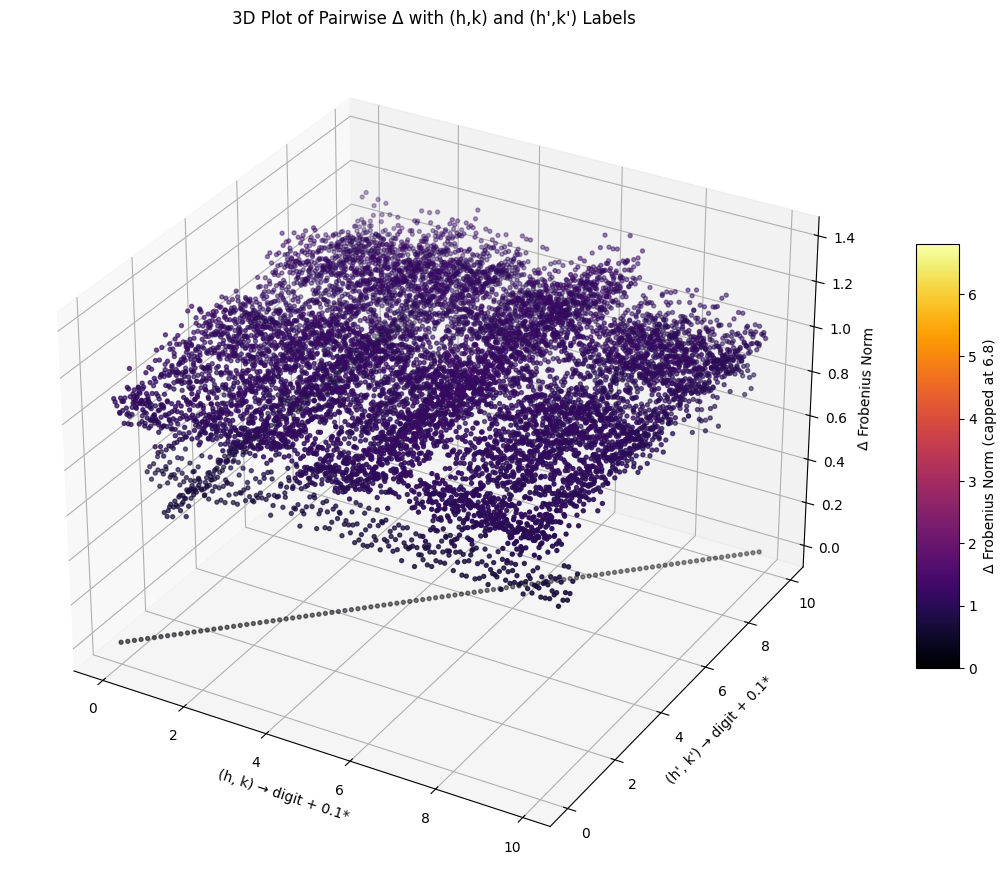

In [10]:
delta, debug_outputs = compute_delta(GS_matrices)


x_coords = []
y_coords = []
z_coords = []

for ((h, k), (h_prime, k_prime)), val in delta.items():
    x_coords.append(h + k/10) 
    y_coords.append(h_prime + k_prime/10)
    z_coords.append(val)

z_array = np.array(z_coords)
print("Delta value distribution:")
print(f"< 0.1     : {np.sum(z_array < 0.1)}")
print(f"0.1–6.0   : {np.sum((z_array >= 0.1) & (z_array < 6.0))}")
print(f"6.0–6.5   : {np.sum((z_array >= 6.0) & (z_array < 6.5))}")
print(f"6.5–7.0   : {np.sum((z_array >= 6.5) & (z_array < 7.0))}")
print(f">= 7.0    : {np.sum(z_array >= 7.0)}")

cap_value = 6.8
clipped_z_coords = [min(z, cap_value) for z in z_coords]

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(x_coords, y_coords, z_coords,
                c=clipped_z_coords, cmap='inferno', s=8,
                vmin=0, vmax=cap_value)

ax.set_xlabel('(h, k) → digit + 0.1*')
ax.set_ylabel('(h\', k\') → digit + 0.1*')
ax.set_zlabel('Δ Frobenius Norm')


plt.title('3D Plot of Pairwise Δ with (h,k) and (h\',k\') Labels')
cbar = fig.colorbar(sc, ax=ax, shrink=0.5, aspect=10)
cbar.set_label(f"Δ Frobenius Norm (capped at {cap_value})")


plt.tight_layout()
plt.show()





This tells us that the delta distribution shows most image pairs have moderate differences, indicating meaningful structural variations in the complex matrix representation. A small number of pairs are nearly identical, while no pairs exhibit extreme differences. This suggests the method effectively captures similarities and differences among digit images.
